# CS145: Project 3 | COVID Loves Non-believers

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Jerry Liu, jerrylzy*
* *Yihan Lin, yihlin*

## Project Overview

---
### Background
The new coronavirus (SARS-Cov-2) has significantly changed our lives. Right now, in the US, new infections are occuring at an all time high, and hospitals are on the brink of another overflow, possibly at a worse level than before. However, some states are doing much better than others.

### Central Question of This Project
This project aims to unearth some key indicators to how well a state does during this pandemic. It compares each state’s COVID-19 situations in the United State to explore the likely culprits of higher infection rate and 

### Important Aspects to Examine
This project will examine whether lower population density, higher average temperatures, higher government stringency indices (stricter lockdown policies) and a decrease in mobility trends contribute to lower new cases per capita and lower death per capita. This project will also examine whether each state's performance varies significantly. The answers to these questions will help us understand the central question - what factors correlelate to how well a state does during the COVID-19 pandemic.

---


## Analysis of Dataset

---

### Introduction

We use four tables to get our data for US COVID-19 trending analysis: COVID Open Data, US Population Density, Government Response Stringency Index, and US 2020 Presidential Election Winner.


### COVID Open Data
We get the COVID Open Data from big query: `bigquery-public-data.covid19_open_data.covid19_open_data`. 

COVID Open Data contains country-level datasets of daily time-series data related to COVID-19 globally.  It merges multiple sources at a fine spatial resolution, using a consistent set of region keys. The dataset contains a total size of 1.31GB data. We use this dataset to get new confirmed cases, new deceased cases, temperatures, and mobility data based on state and date.


### US Population Density

We get the US Population Density Data from https://worldpopulationreview.com/state-rankings/state-densities. 

US Population density dataset contains the population density of all US states and DC in 2020. The density shows number of people per square mile, and is calculated by state population in 2020 dividing by state land area(square mile).


### Government Response Stringency Index

We get the Government Response Stringency Index Data from https://data.humdata.org/dataset/oxford-covid-19-government-response-tracker.

We used this to cleansing data from the Oxford government stringency index csv file. Here, we added 28 days because usually it will take weeks for government's easing or increasing restrictions to show up in cases. We also removed incomplete data where the stringency indices are not available.
```sql
SELECT
  RegionName state,
  DATE_ADD(PARSE_DATE("%Y%m%d", CAST(Date AS STRING)), INTERVAL 28 DAY) date,
  StringencyIndex,
  StringencyLegacyIndex,
  GovernmentResponseIndex,
  ContainmentHealthIndex,
  EconomicSupportIndex
FROM `cs145-fa20-290805.Project3.gov_stringency`  
WHERE CountryCode = 'USA' AND StringencyIndex IS NOT NULL AND RegionName IS NOT NULL
ORDER BY RegionName, date
```


### US 2020 Presidential Election Winner
This dataset contains the state name, its abbreviation and the winner party of the 2020 presidential election. We just use the winner party for coloring and illustration purposes during the data exploration section to demonstrate the disparity between red states and blue states.
This table is created by ourselves based on the [current official call from AP](https://apps.npr.org/elections20-interactive/#/president).


### Relationships between datasets
#### Primary Keys
* COVID Open Data's primary keys are `date` and `location_key`.

* US Population Density's primary key is `state`.

* US Government Response Stringency Index's primary keys are `state` and `date`.

* US 2020 Presidential Election Winner's primary key is `state`.

#### Foreign Keys

* COVID Open Data's foreign key is `date` and `subregion1_name`, which could refer to US Population Density's and US Government Response Stringency Index's primary keys `date` and `state`.

* US Population Density's foreign key is `state`, which refers to COVID Open Data's `subregion1_name`.

* US Government Response Stringency Index's foreign keys are `state` and `date`, which refers to COVID Open Data's `subregion1_name` and `date`.

* US 2020 Presidential Election Winner's foreign key is `state`, which refers to COVID Open Data's `subregion1_name`, US Population Density and US Government Response Stringency Index's `state`.

#### How we join them

* We join COVID Open Data and US Population Density on `covid19_open_data.subregion1_name = pop_density.state`.

* We join COVID Open Data and US Government Response Stringency Index on `covid19_open_data.subregion1_name = us_gov_stringency.state` and `covid19_open_data.date = us_gov_stringency.date`.

* We join US Population Density and US Government Response Stringency Index on `pop_density.state = us_gov_stringency.state`.

----

## Data Exploration
In this section, we will analyze the datasets and use feature engineering to come up with our features for our model for prediction.

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "cs145-yihlin"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
# Add imports for any visualization libraries you may need
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

In [ ]:
# Import numpy and pandas
import numpy as np
import pandas as pd

### 1 Engineered Features
We define *per capita* to be per 100,000 people.
#### 1.1 New Cases per Capita
Here, we *engineered* a feature `new_confirmed_per_capita`:
$$
\frac{\text{total number of newly confirmed cases}}{\text{population}} \cdot 100000 \ \ \forall\ \text{state} \in \text{US}
$$
We engineered this feature because the total number of new cases are not representative of a state's pandemic situation. For example, if North Dakota and California both have 1000 cases per day, we would say that California has done a great job while North Dakota, which shouldn't even be a state to begin with, hasn't done so well.

### 1.2 New Deaths per Capita
Similar to the one above, we *engineered* a feature `new_deceased_per_capita` to be more representative of a state's situation:
$$
\frac{\text{total number of newly deceased cases}}{\text{population}} \cdot 100000 \ \ \forall\ \text{state} \in \text{US}
$$

### 1.3 New Dates for Government Stringency Index
Government policies and responses require time to show its effect in daily new cases and deaths. This may not count as an engineered feature, but we did calculate a new value for it.
$$
\text{Date}_\text{new} = \text{Date}_\text{original} + 28
$$

### 2 Average Temperatures
As we know, coronaviruses generally do not like high temperatures. They can also spread quickly in high temperature environments, but they do so more effectively in [colder environments](https://covid19.nj.gov/faqs/coronavirus-information/about-the-virus/will-the-coronavirus-survive-in-the-refrigerator-or-freezer#direct-link).

Moreover, people tend to congregate indoors in cold weather where coronaviruses spread the most effectively. According to [Dr. Fauci](https://www.forbes.com/sites/carlieporterfield/2020/11/01/fauci-us-could-not-be-positioned-more-poorly-for-winter-and-coronavirus/?sh=22e010396e13), the US cannot be positioned more poorly for the coming fall and winter seasons when temperatures are low.

Therefore, we would like to find whether there was a relationship between the average temperatures and new cases / deaths per capita.

Note that we chose 5/30 as the starting point because some people weren't aware of this pandemic yet before that.

In [ ]:
%%bigquery --project $project_id q21

SELECT
  date,
  subregion1_name state,
  SUM(new_confirmed / population * 100000) new_confirmed_per_capita,
  SUM(new_deceased / population * 100000) new_deceased_per_capita,
  AVG(average_temperature_celsius) avg_temp_celsius
FROM `bigquery-public-data.covid19_open_data.covid19_open_data` covid19_open_data,
`cs145-fa20-290805.Project3.us_pop_density` pop_density
WHERE date > "2020-05-30" AND covid19_open_data.subregion1_name = pop_density.state
GROUP BY covid19_open_data.subregion1_name, date

#### 2.1 New Cases per Capita

##### 2.1.1 Per State
Here, we look at how well each state is doing. We will randomly select four states for this analysis. As we can see from the plot of these four states, colder temperatures do have a negative correlation with the number of new confirmed cases per capita.

In [ ]:
# Drop NAN's
q21 = q21.dropna()

states = q21['state'].unique()
n = 4
rand_states = np.random.choice(states, n, replace=False)

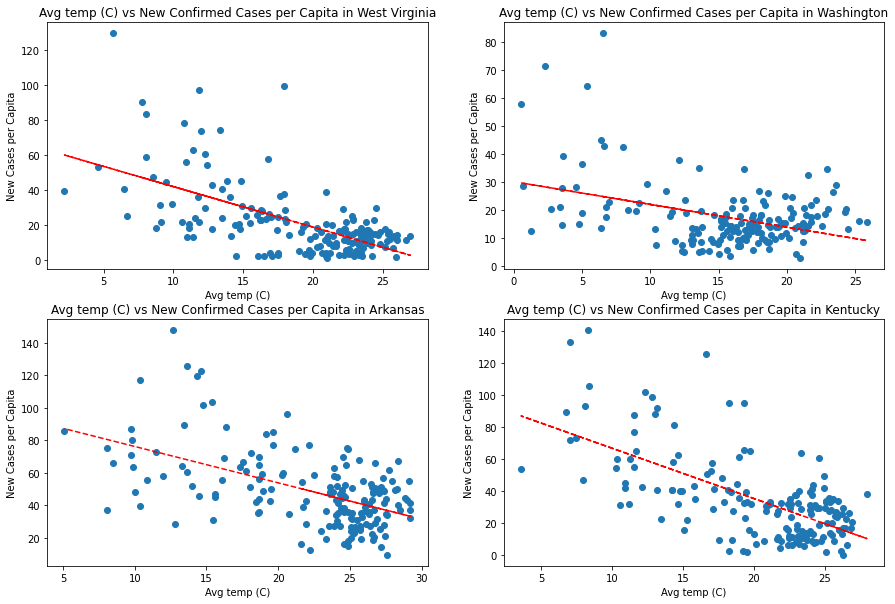

In [ ]:
plt.figure(figsize=(15, 10))

for i in range(len(rand_states)):
  state_data = q21.loc[q21['state'] == rand_states[i]]

  plt.subplot(n / 2, 2, i + 1)
  x = state_data["avg_temp_celsius"]
  y = state_data["new_confirmed_per_capita"]
  plt.scatter(x, y)
  plt.title(f"Avg temp (C) vs New Confirmed Cases per Capita in {rand_states[i]}")
  # plt.xscale("log")
  plt.xlabel("Avg temp (C)")
  plt.ylabel("New Cases per Capita")

  z = np.polyfit(x, y, 1)
  p = np.poly1d(z)
  plt.plot(x,p(x),"r--")


##### 2.1.2 Random Sample in All States
Here, we will randomly sample 1000 points and see the trends. As we can see from the plot of the random sample of 1000 data points from all states, colder temperatures do have a negative correlation with the number of new confirmed cases per capita.

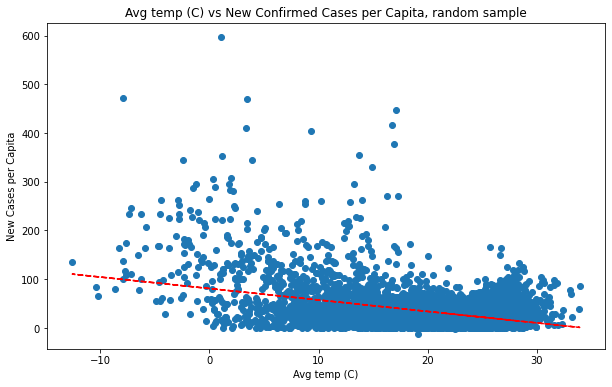

In [ ]:
q21_sampled = q21.sample(n=5000)

plt.figure(figsize=(10, 6))

x = q21_sampled["avg_temp_celsius"]
y = q21_sampled["new_confirmed_per_capita"]
plt.scatter(x, y)
plt.title("Avg temp (C) vs New Confirmed Cases per Capita, random sample")
plt.xlabel("Avg temp (C)")
plt.ylabel("New Cases per Capita")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

#### 2.2 New Deaths per Capita


##### 2.2.1 Per State
Similar to the analysis in 2.1.1, we will look at the relationship between new deaths per capita and average temperatures in four randomly selected states.

Here, we see that while in three of the four states selected, all confirm the theory that colder temperatures may cause more infections and deaths. However, Maryland has the opposite trend.

Maryland was hit particularly hard early on by COVID-19 when doctors and nurses do not know much about this virus and hospitals were overrun. However, this dataset specifically ignored that part by selecting data only after 5/30. Maryland's governor has done a stellar job at controlling this virus. The death per capita was almost always at single digit after 5/30. Therefore, this anomaly do not justify overturning our analysis.

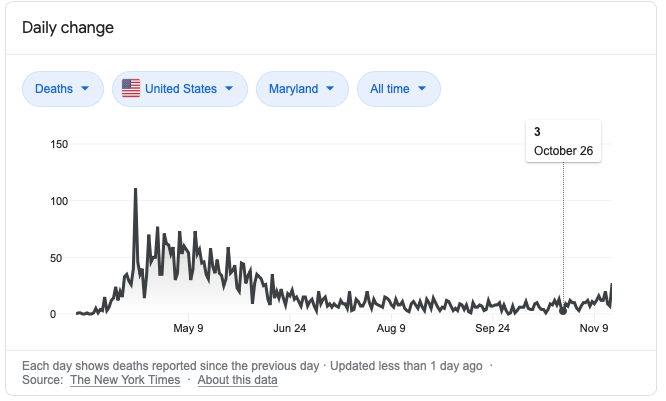

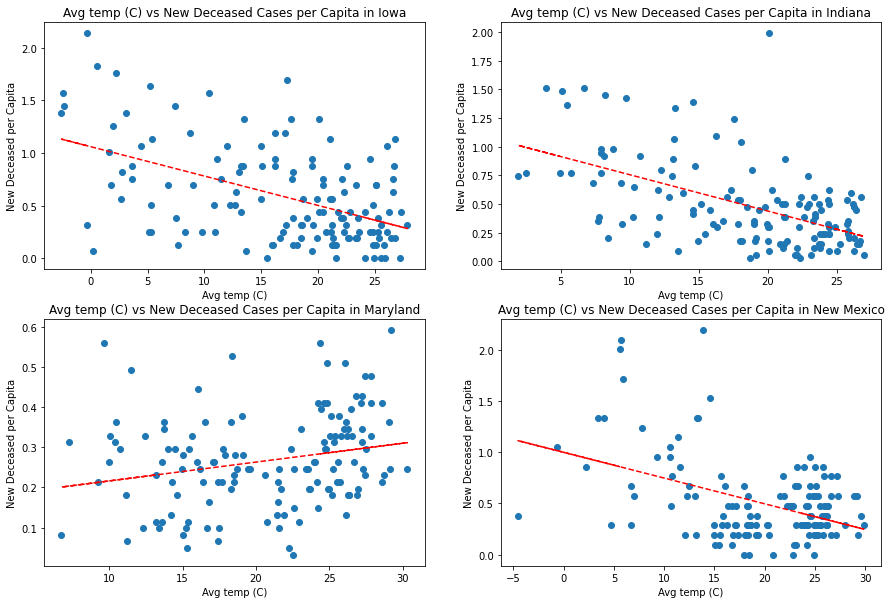

In [ ]:
plt.figure(figsize=(15, 10))

for i in range(len(rand_states)):
  state_data = q21.loc[q21['state'] == rand_states[i]]

  plt.subplot(n / 2, 2, i + 1)
  x = state_data["avg_temp_celsius"]
  y = state_data["new_deceased_per_capita"]
  plt.scatter(x, y)
  plt.title(f"Avg temp (C) vs New Deceased Cases per Capita in {rand_states[i]}")
  # plt.xscale("log")
  plt.xlabel("Avg temp (C)")
  plt.ylabel("New Deceased per Capita")

  z = np.polyfit(x, y, 1)
  p = np.poly1d(z)
  plt.plot(x,p(x),"r--")


##### 2.2.2 Random Sample in All States
Similar to what we did in 2.1.2, we will randomly sample 1000 data points. As we can see from this graph, there was a very weak negative correlation between average temperature and new deaths per capita. Therefore, we don't think this will be useful to predicting `new_deceased_per_capita`. 

One theory to explain this is that because hospitals have not been overrun yet (they will be in the near future), people can still get adequate treatment from Remdesivir and in-time oxygen supply. Therefore, as we can also see from the graph, new deaths per capita is very low in most cases, which cannot provide us with much information about how average temperatures can affect death rates.

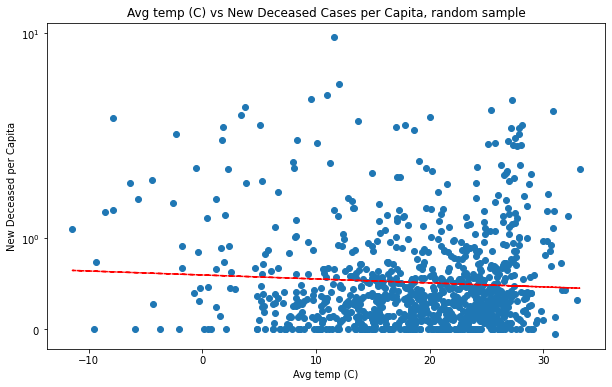

In [ ]:
q21_sampled = q21.sample(n=1000)

plt.figure(figsize=(10, 6))

x = q21_sampled["avg_temp_celsius"]
y = q21_sampled["new_deceased_per_capita"]
plt.scatter(x, y)
plt.title("Avg temp (C) vs New Deceased Cases per Capita, random sample")
plt.yscale("symlog")
plt.xlabel("Avg temp (C)")
plt.ylabel("New Deceased per Capita")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

### 3 Recreational Mobility Trends
Here, we will analyze the "mobility trends for places like restaurants, cafes, shopping centers, theme parks, museums, libraries, and movie theaters" and how it relates to the number of new cases per capita.

In [ ]:
%%bigquery --project $project_id q51

SELECT
  covid19_open_data.date,
  subregion1_name state,
  SUM(new_confirmed / population * 100000) new_confirmed_per_capita,
  SUM(new_deceased / population * 100000) new_deceased_per_capita,
  AVG(mobility_retail_and_recreation) mobility_retail_and_recreation
FROM `bigquery-public-data.covid19_open_data.covid19_open_data` covid19_open_data,
`cs145-fa20-290805.Project3.us_pop_density` pop_density
WHERE covid19_open_data.date > "2020-05-30" AND covid19_open_data.subregion1_name = pop_density.state
GROUP BY covid19_open_data.subregion1_name, date

#### 3.1 New Cases per Capita

##### 3.1.1 Per State
Here, we look at how well each state is doing. We will randomly select $N = 8$ states for this analysis. As we can see from the plots, there is a clear negative correlation between mobility trends and the number of new cases per capita. This is because when cases are spiking up, government tend to issue stricter guidelines, and people tend to go out less which will result in a negative trend.

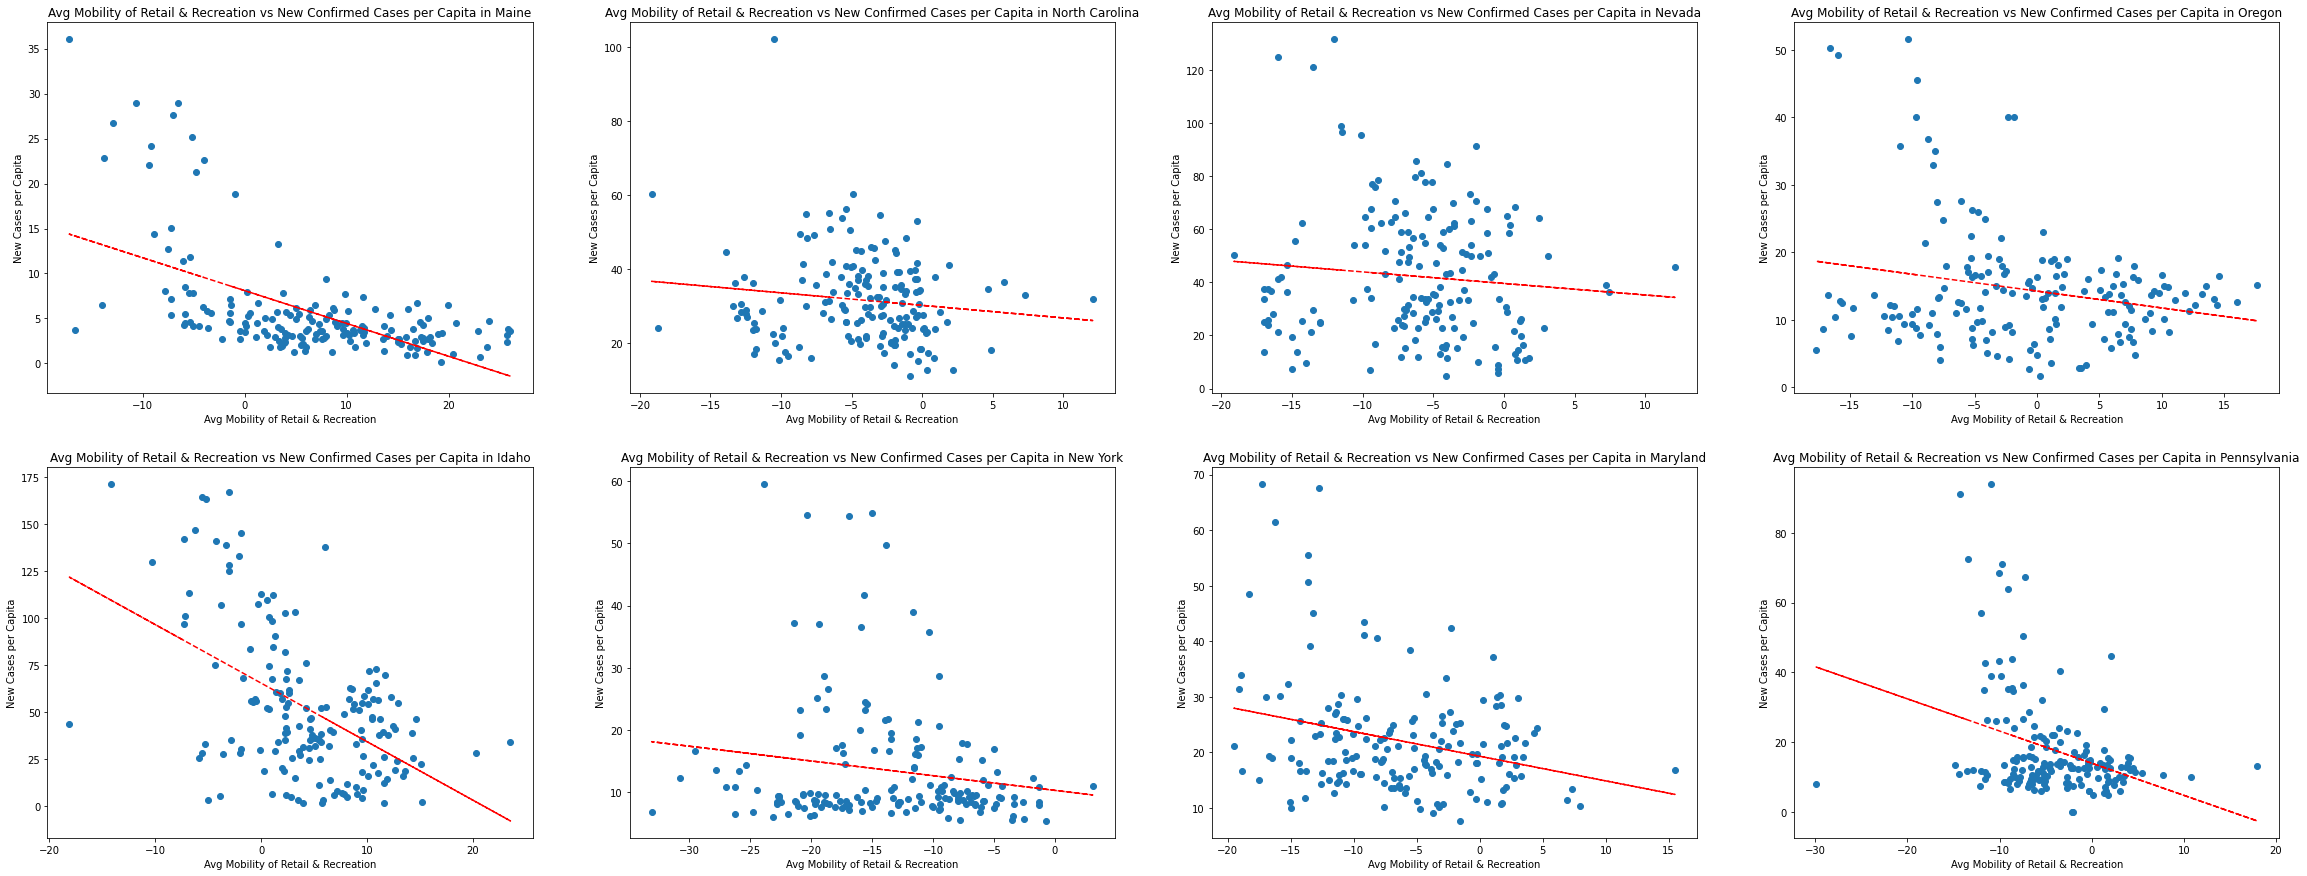

In [ ]:
# Drop NAN's
q51 = q51.dropna()

states = q51['state'].unique()
n = 8
rand_states = np.random.choice(states, n, replace=False)

plt.figure(figsize=(40, 15))

for i in range(len(rand_states)):
  state_data = q51.loc[q51['state'] == rand_states[i]]

  plt.subplot(n / 4, 4, i + 1)
  x = state_data["mobility_retail_and_recreation"]
  y = state_data["new_confirmed_per_capita"]
  plt.scatter(x, y)
  plt.title(f"Avg Mobility of Retail & Recreation vs New Confirmed Cases per Capita in {rand_states[i]}")
  # plt.xscale("log")
  plt.xlabel("Avg Mobility of Retail & Recreation")
  plt.ylabel("New Cases per Capita")

  z = np.polyfit(x, y, 1)
  p = np.poly1d(z)
  plt.plot(x,p(x),"r--")

##### 3.1.2 Random Sample in All States

Here, we will randomly sample 1000 points and see the trends. As we can see from the plot of the random sample of 1000 data points from all states, mobility trends have a slight negative correlation with the number of new confirmed cases per capita.

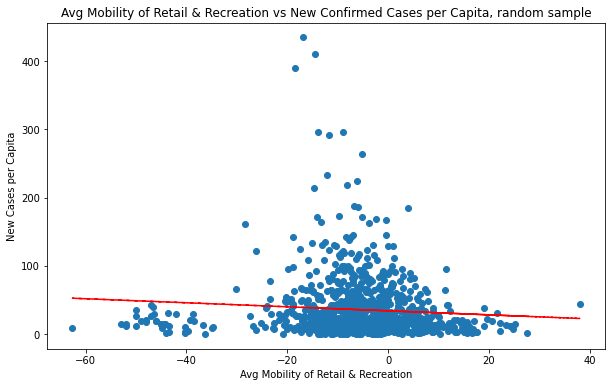

In [ ]:
q51_sampled = q51.sample(n=1000)

plt.figure(figsize=(10, 6))

x = q51_sampled["mobility_retail_and_recreation"]
y = q51_sampled["new_confirmed_per_capita"]
plt.scatter(x, y)
plt.title("Avg Mobility of Retail & Recreation vs New Confirmed Cases per Capita, random sample")
# plt.yscale("symlog")
plt.xlabel("Avg Mobility of Retail & Recreation")
plt.ylabel("New Cases per Capita")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

#### 3.2 New Deaths per Capita

##### 3.2.1 Per State
Here, we look at how well each state is doing. We will randomly select $N = 8$ states for this analysis. As we can see from the plots, there is a clear negative correlation between mobility trends and the number of new deaths per capita. This is because when cases are spiking up, government tend to issue stricter guidelines, and people tend to go out less which will result in a negative trend.

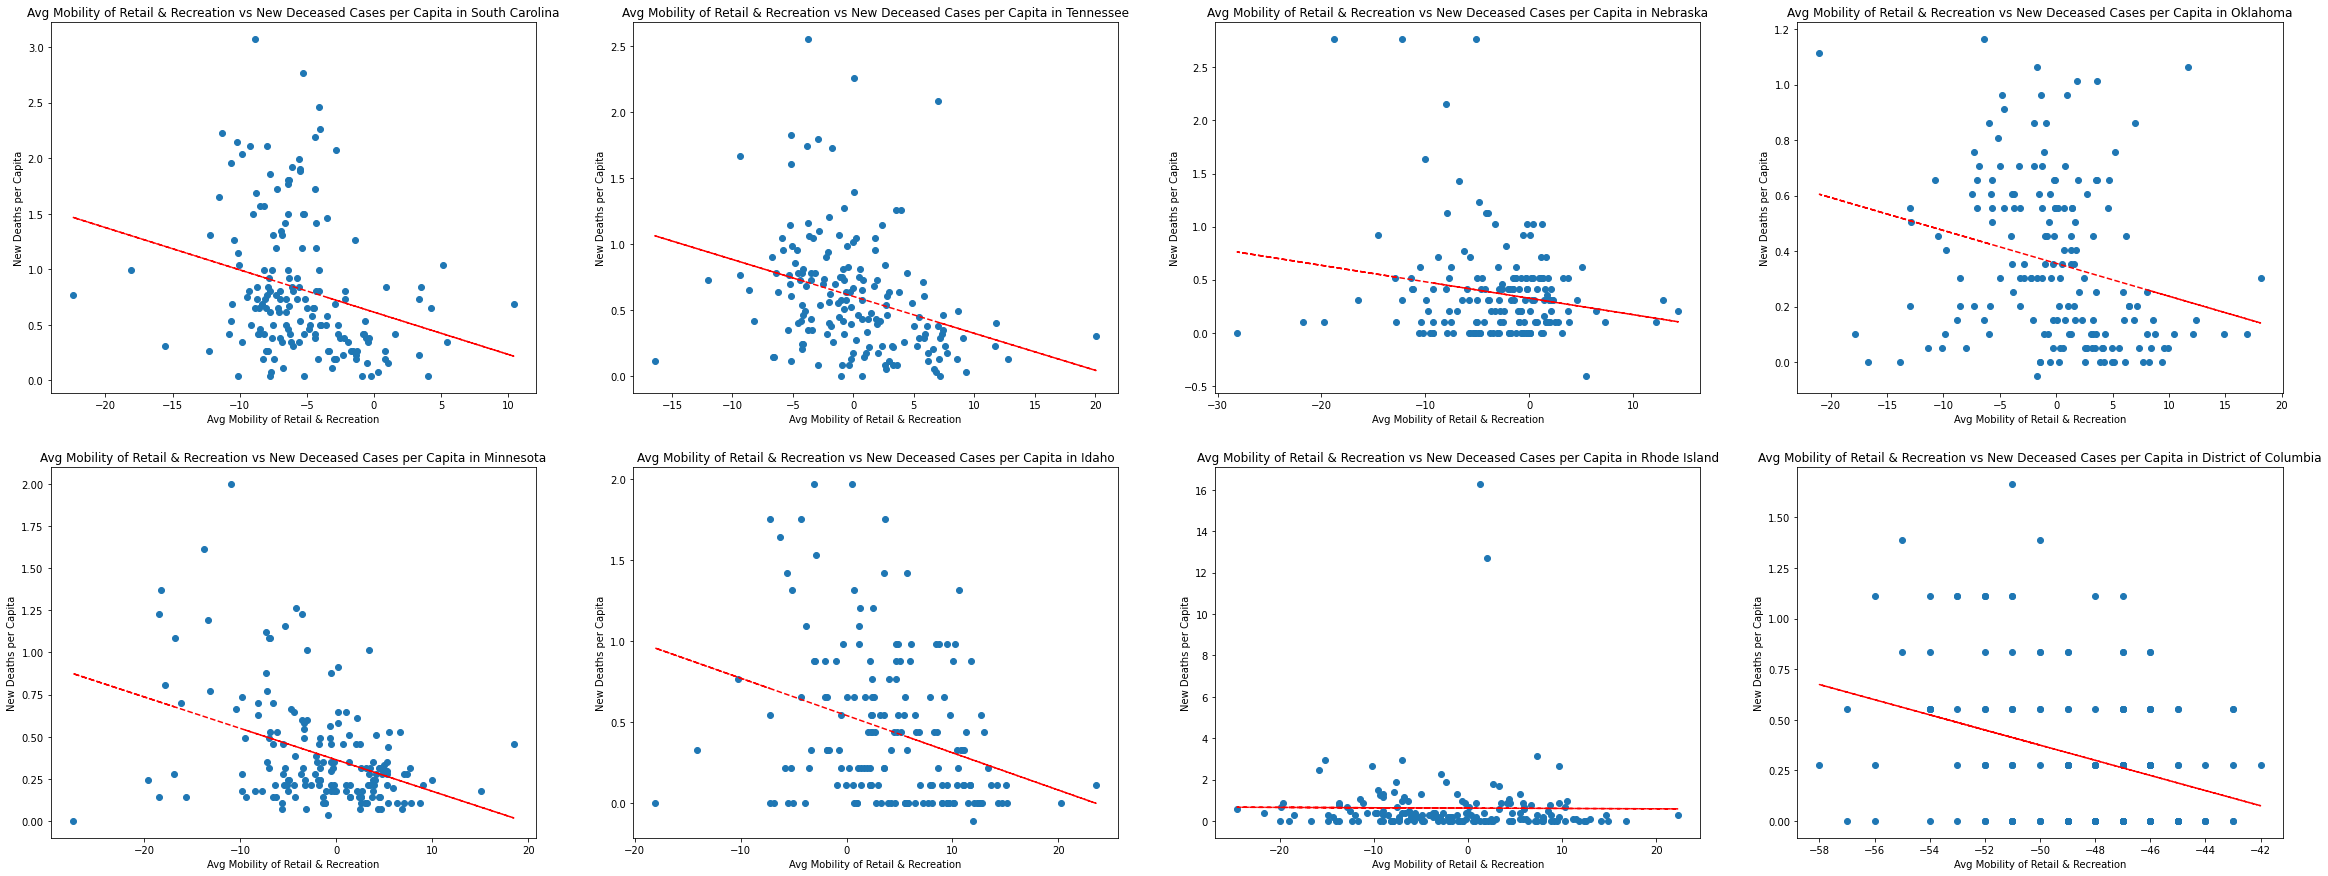

In [ ]:
# Drop NAN's
q51 = q51.dropna()

states = q51['state'].unique()
n = 8
rand_states = np.random.choice(states, n, replace=False)

plt.figure(figsize=(40, 15))

for i in range(len(rand_states)):
  state_data = q51.loc[q51['state'] == rand_states[i]]

  plt.subplot(n / 4, 4, i + 1)
  x = state_data["mobility_retail_and_recreation"]
  y = state_data["new_deceased_per_capita"]
  plt.scatter(x, y)
  plt.title(f"Avg Mobility of Retail & Recreation vs New Deceased Cases per Capita in {rand_states[i]}")
  # plt.xscale("log")
  plt.xlabel("Avg Mobility of Retail & Recreation")
  plt.ylabel("New Deaths per Capita")

  z = np.polyfit(x, y, 1)
  p = np.poly1d(z)
  plt.plot(x,p(x),"r--")

##### 3.2.2 Random Sample in All States

Here, we will randomly sample 1000 points and see the trends. As we can see from the plot of the random sample of 1000 data points from all states, mobility trends have a slight negative correlation with the number of new deceased cases per capita. However, we do not think this can be a strong enough feature to predict new deaths per capita along with average temperatures because many other features are also not usable.

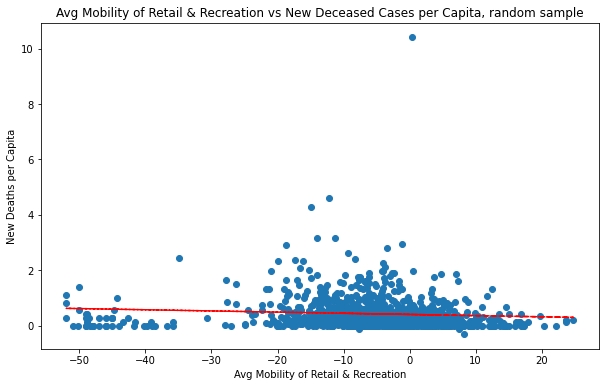

In [ ]:
q51_sampled = q51.sample(n=1000)

plt.figure(figsize=(10, 6))

x = q51_sampled["mobility_retail_and_recreation"]
y = q51_sampled["new_deceased_per_capita"]
plt.scatter(x, y)
plt.title("Avg Mobility of Retail & Recreation vs New Deceased Cases per Capita, random sample")
# plt.yscale("symlog")
plt.xlabel("Avg Mobility of Retail & Recreation")
plt.ylabel("New Deaths per Capita")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

### 4 Population Density

COVID-19 spreads very easily through close contact from person to person, and sometimes can be spread by airborne transmission, which makes it to be the most contagious viruses known to affect people. In some large density cities with high turnover rate like New York City and London, COVID-19 confirmed cases has been explosive increasing. Hence, we think that population density could be one of the key factors in the spreading of the coronaviruses. We would like to figure out that whether there's a relationship between COVID-19 confirmed cases and state population density.

In [ ]:
%%bigquery --project $project_id q41

SELECT
  subregion1_name state,
  SUM(new_confirmed / population * 100000) cumulative_new_confirmed_per_capita,
  SUM(new_deceased / population * 100000) cumulative_new_deceased_per_capita,
  AVG(pop_density.density) density
FROM `bigquery-public-data.covid19_open_data.covid19_open_data` covid19_open_data,
`cs145-fa20-290805.Project3.us_pop_density` pop_density
WHERE date > "2020-05-30" AND covid19_open_data.subregion1_name = pop_density.state
GROUP BY covid19_open_data.subregion1_name

#### 4.1 New Cases per Capita
We compare all the states to see how the states' density relate to cumulative new cases per capita. In the plot, however, we find a negative correlation between population density and cumulative confirmed cases.

Some states with large density such as New Jersey and Massachusetts controlled the COVID-19 very well, and their cumulative confirmed cases number becomes relatively low while comparing with other states. Some states with low density such as North Dakota and South Dakota, didn't have effective measures to intervene COVID-19's spreading, and they got much more cumulative new confirmed cases per capita than other states.

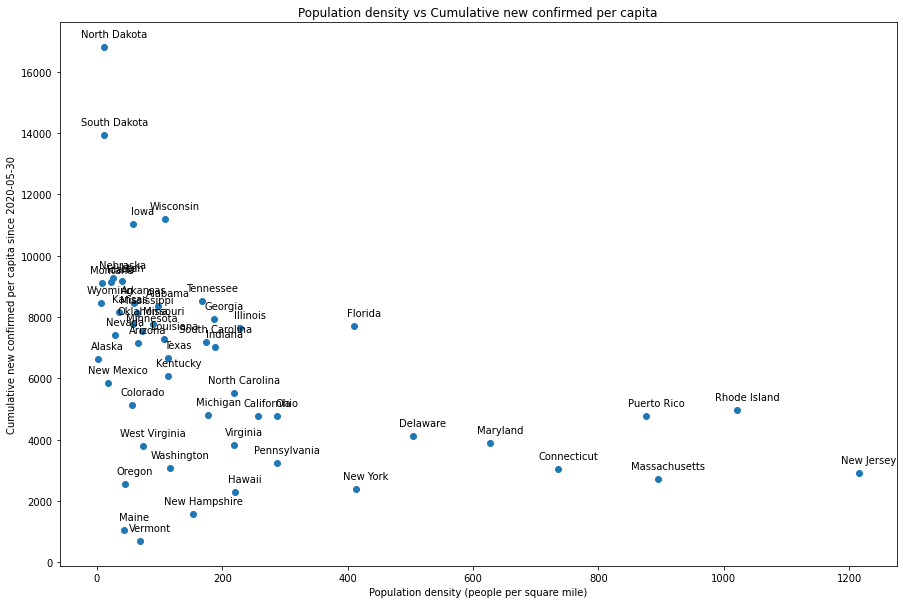

In [ ]:
# Drop NAN's
q41 = q41.dropna()

states = q41['state'].unique()

plt.figure(figsize=(15, 10))
xs = q41["density"]
ys = q41["cumulative_new_confirmed_per_capita"]
zs = q41["state"]
plt.scatter(xs, ys)
plt.title("Population density vs Cumulative new confirmed per capita")
plt.xlabel("Population density (people per square mile)")
plt.ylabel("Cumulative new confirmed per capita since 2020-05-30")

for x,y, z in zip(xs,ys,zs):
    label = z
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(10,10),
                 ha='center')

#### 4.2 New Deaths per Capita
We also compare all the states to see how the states' density relate to cumulative death cases per capita. In the plot, we find a slight negative correlation between population density and cumulative death cases. We also found that states with high population density, such as New Jersey, performed worse than their neighboring states with a lower population density, such as New York and Connecticut. Therefore

Some states with large density such as Connecticut and Maryland controlled the COVID-19 very well, and their cumulative death cases number becomes relatively low while comparing with other states. Some states with low density such as North Dakota and Mississippi, didn't have effective measures to intervene COVID-19's spreading, and they got much more cumulative new death cases per capita than other states.

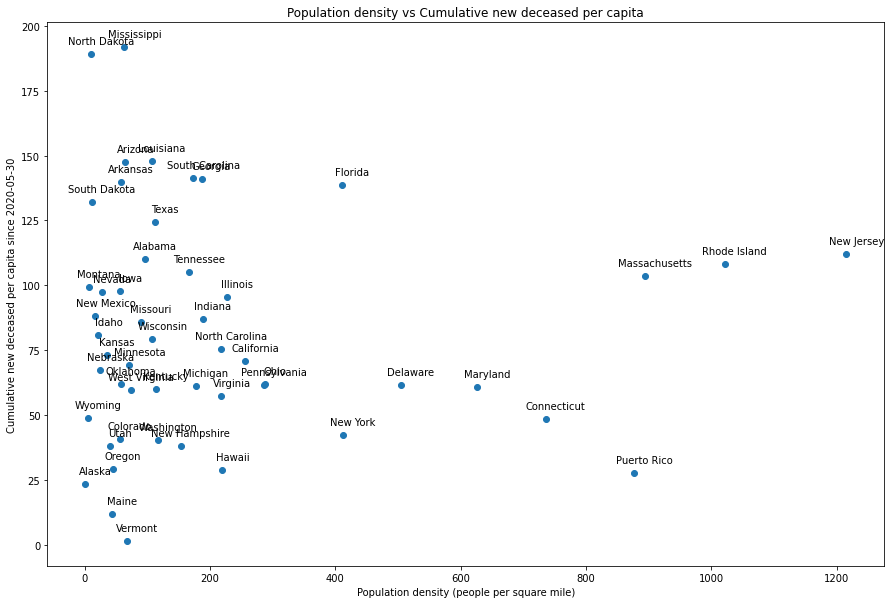

In [ ]:
plt.figure(figsize=(15, 10))
xs = q41["density"]
ys = q41["cumulative_new_deceased_per_capita"]
zs = q41["state"]
plt.scatter(xs, ys)
plt.title("Population density vs Cumulative new deceased per capita")
plt.xlabel("Population density (people per square mile)")
plt.ylabel("Cumulative new deceased per capita since 2020-05-30")

for x,y,z in zip(xs,ys,zs):
    label = z
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(10,10),
                 ha='center')

### 5 Government Stringency Index
Government stringency index defines how strongly a government responds to the COVID-19 pandemic policy-wise. The larger the number, the stronger the policy response is. We want to explore whether stricter restrictions can help slow the spread of the virus.

#### 5.1 New Cases per Capita

##### 5.1.1 Per State
Here, we want to see the relationship between government responses and new cases per capita in each state. Just like before, we will randomly select $N = 9$ states to analyze. Note that here we use $\min{(\text{StringencyIndex})}$ because it's the same for each state. It doesn't matter whether we use min, max or avg.

As we can see from the graph, an increase in daily new cases definitely follows a lower stringency index. 

In [ ]:
%%bigquery --project $project_id q311

SELECT
  covid19_open_data.date,
  subregion1_name state,
  SUM(new_confirmed / population * 100000) new_confirmed_per_capita,
  SUM(new_deceased / population * 100000) new_deceased_per_capita,
  MIN(us_gov_stringency.StringencyIndex) stringency
FROM `bigquery-public-data.covid19_open_data.covid19_open_data` covid19_open_data,
`cs145-fa20-290805.Project3.us_pop_density` pop_density,
`cs145-fa20-290805.Project3.us_gov_stringency_processed` us_gov_stringency
WHERE covid19_open_data.date = us_gov_stringency.date AND pop_density.state = us_gov_stringency.state AND covid19_open_data.subregion1_name = pop_density.state #AND covid19_open_data.date > "2020-06-30"
GROUP BY covid19_open_data.subregion1_name, covid19_open_data.date
ORDER BY covid19_open_data.date

In [ ]:
# Drop NAN's
q311 = q311.dropna()

states = q311['state'].unique()
n = 9
rand_states = np.random.choice(states, n, replace=False)


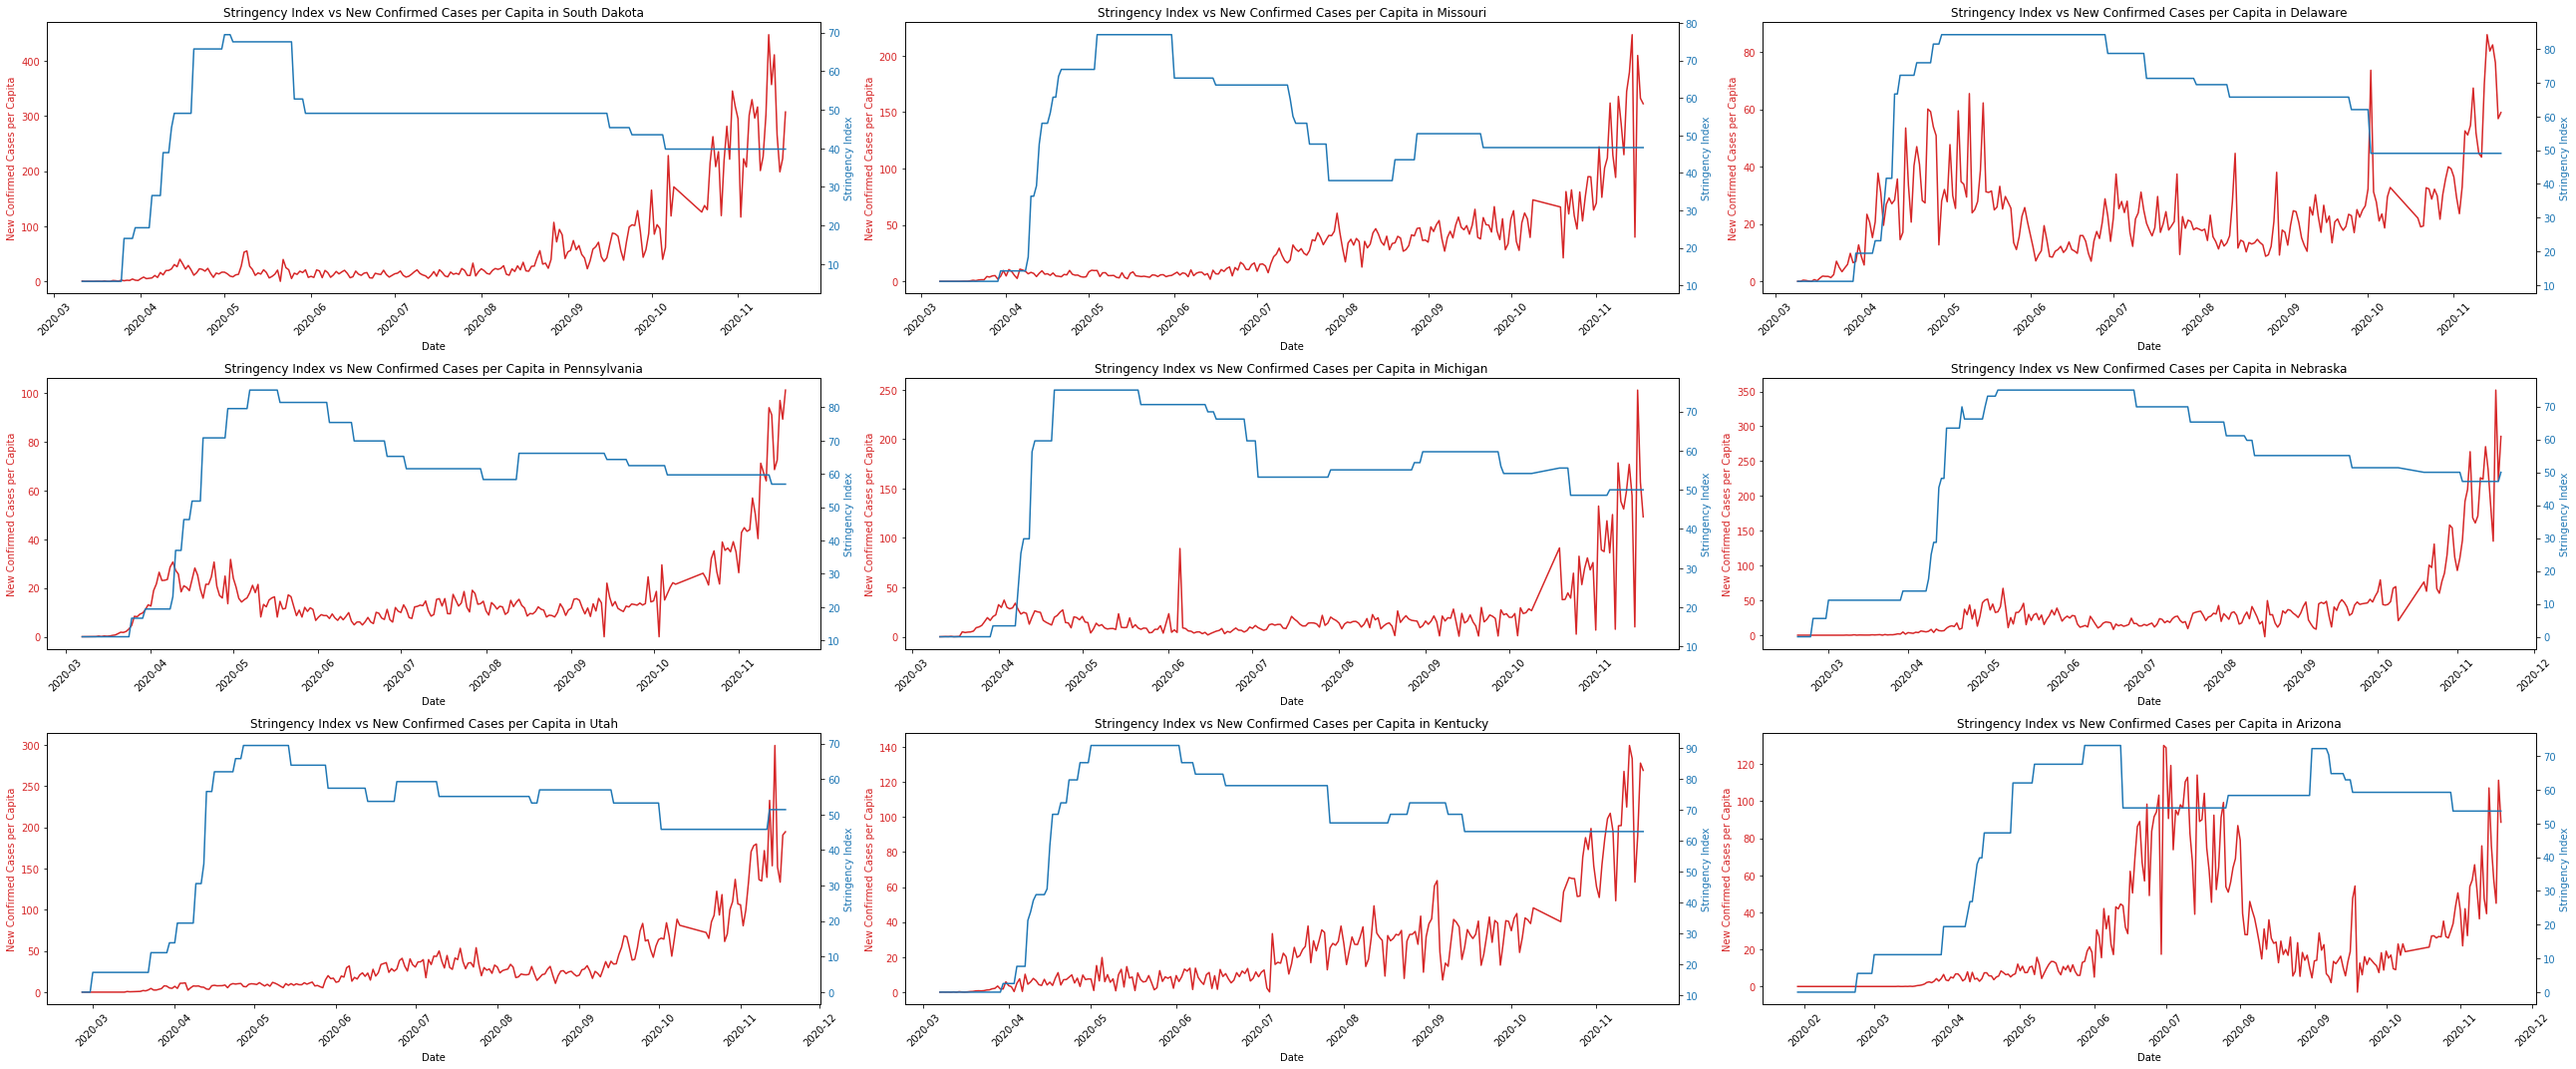

In [ ]:
fig = plt.figure(figsize=(36, 15))
spec = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

for i in range(len(rand_states)):
  state_data = q311.loc[q311['state'] == rand_states[i]]
  
  ax1 = fig.add_subplot(spec[int(i / 3), i % 3])
  color = 'tab:red'
  x = state_data["date"]
  y = state_data["new_confirmed_per_capita"]
  z = state_data["stringency"]
  ax1.set_xlabel('Date')
  ax1.set_ylabel('New Confirmed Cases per Capita', color=color)
  ax1.plot(x, y, color=color)
  ax1.tick_params(axis='x', labelrotation=45)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel('Stringency Index', color=color)  # we already handled the x-label with ax1
  ax2.plot(x, z, color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  ax1.set_title(f"Stringency Index vs New Confirmed Cases per Capita in {rand_states[i]}")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.show()



##### 5.1.2 Average from All States
Here, we compare the average stringency index against the sum of new cases per capita. As we can see, there is indeed a negative correlation between the average stringency index and the sum of new cases per capita after April.

In [ ]:
%%bigquery --project $project_id q312

SELECT
  covid19_open_data.date,
  SUM(new_confirmed / population * 100000) new_confirmed_per_capita,
  SUM(new_deceased / population * 100000) new_deceased_per_capita,
  AVG(us_gov_stringency.StringencyIndex) stringency
FROM `bigquery-public-data.covid19_open_data.covid19_open_data` covid19_open_data,
`cs145-fa20-290805.Project3.us_pop_density` pop_density,
`cs145-fa20-290805.Project3.us_gov_stringency_processed` us_gov_stringency
WHERE covid19_open_data.date = us_gov_stringency.date AND pop_density.state = us_gov_stringency.state AND covid19_open_data.subregion1_name = pop_density.state
GROUP BY covid19_open_data.date
ORDER BY covid19_open_data.date

<Figure size 720x432 with 0 Axes>

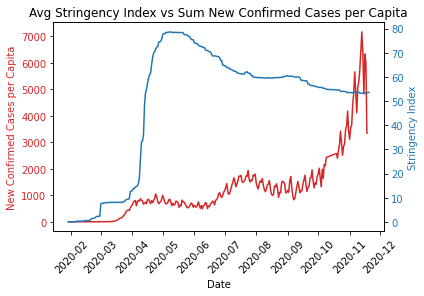

In [ ]:
plt.figure(figsize=(10, 6))

fig, ax1 = plt.subplots()
color = 'tab:red'
x = q312["date"]
y = q312["new_confirmed_per_capita"]
z = q312["stringency"]
ax1.set_xlabel('Date')
ax1.set_ylabel('New Confirmed Cases per Capita', color=color)
ax1.plot(x, y, color=color)
ax1.tick_params(axis='x', labelrotation=45)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Stringency Index', color=color)  # we already handled the x-label with ax1
ax2.plot(x, z, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title(f"Avg Stringency Index vs Sum New Confirmed Cases per Capita")
# plt.xscale("log")

plt.show()

#### 5.2 New Deaths per Capita


##### 5.2.1 Per State
Like before, we randomly chooose $N = 9$ states to analyze. Because deaths per capital really depend on many factors, such as treatment, number of hospital beds, viral load, mask usage and so on, it is difficult to make a consistent connection between the government stringency index and the number of new deaths per capita. Moreover, deaths usually lag behind new cases by weeks. Therefore, we will not use this feature to predict the number of new deaths per capita.


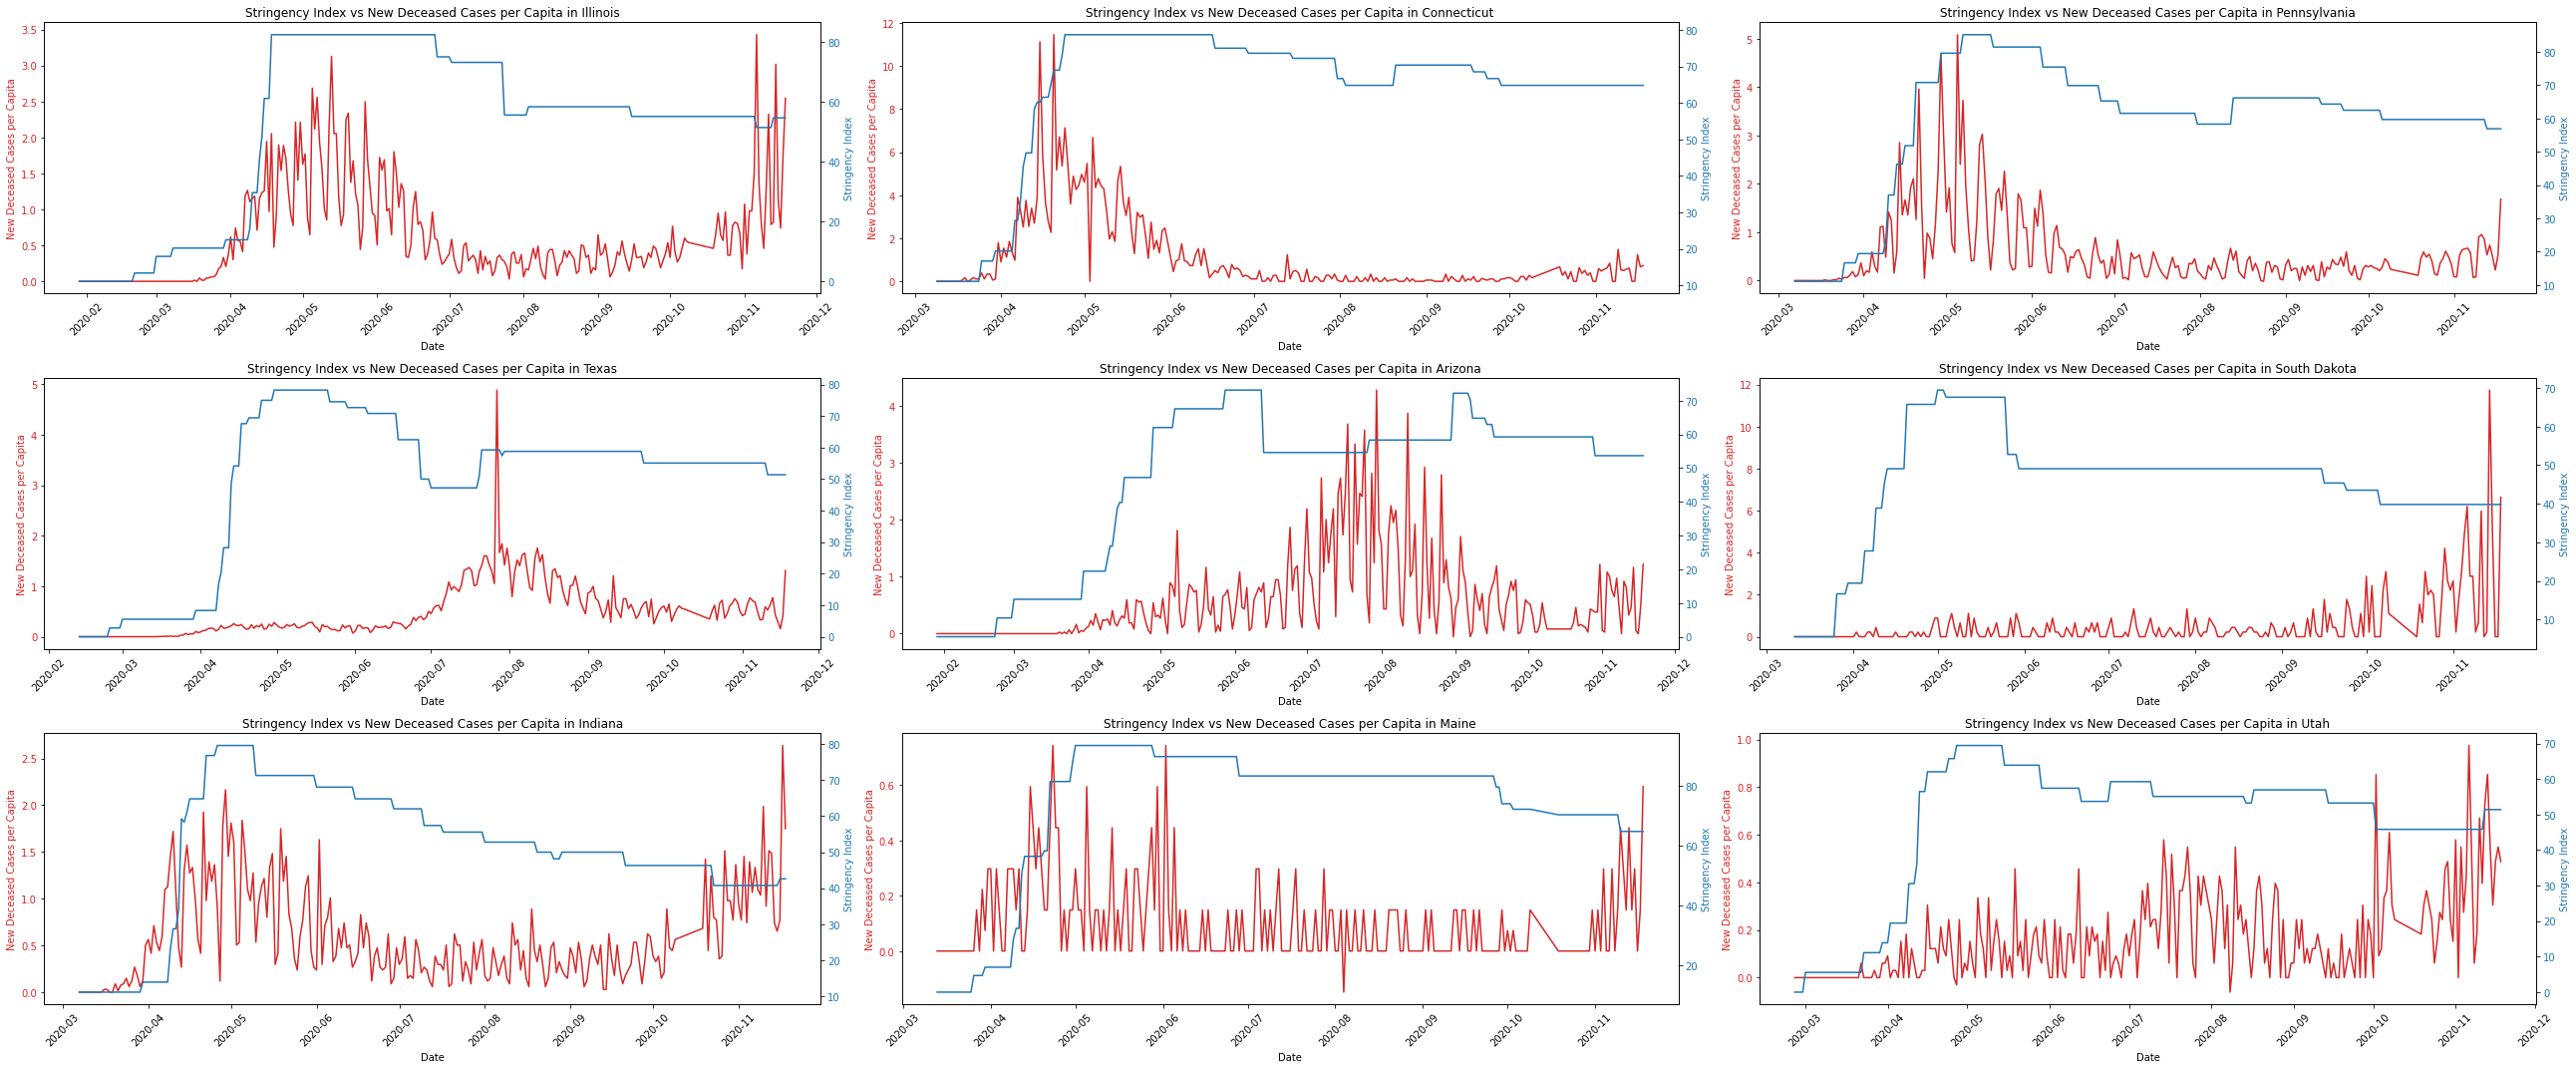

In [ ]:
# Drop NAN's
q311 = q311.dropna()

states = q311['state'].unique()
n = 9
rand_states = np.random.choice(states, n, replace=False)

fig = plt.figure(figsize=(36, 15))
spec = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

for i in range(len(rand_states)):
  state_data = q311.loc[q311['state'] == rand_states[i]]
  
  ax1 = fig.add_subplot(spec[int(i / 3), i % 3])
  color = 'tab:red'
  x = state_data["date"]
  y = state_data["new_deceased_per_capita"]
  z = state_data["stringency"]
  ax1.set_xlabel('Date')
  ax1.set_ylabel('New Deceased Cases per Capita', color=color)
  ax1.plot(x, y, color=color)
  ax1.tick_params(axis='x', labelrotation=45)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel('Stringency Index', color=color)  # we already handled the x-label with ax1
  ax2.plot(x, z, color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  ax1.set_title(f"Stringency Index vs New Deceased Cases per Capita in {rand_states[i]}")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.show()




### 6 States
An obvious feature will be the state name itself, which serves as a category, because it relates to many other factors not touched in this project due to lack of data - hospital bed availability, the political stance of the state, the number of mask denialists, etc. The analysis below showed that it can vary significantly in terms of each state's cumulative cases after 5/30. For example, you can see that the winner party of the 2020 presidential election seems related to how many the cumulative cases after 5/30 a state has.

In [ ]:
%%bigquery --project $project_id q6

SELECT
  subregion1_name state,
  SUM(new_confirmed / population * 100000) cumulative_new_confirmed_per_capita,
  election.election_winner_party 
FROM `bigquery-public-data.covid19_open_data.covid19_open_data` covid19_open_data,
`cs145-fa20-290805.Project3.us_pop_density` pop_density,
`cs145-fa20-290805.Project3.us_2020_election_states` election
WHERE date > "2020-05-30" AND covid19_open_data.subregion1_name = pop_density.state AND pop_density.state = election.state
GROUP BY covid19_open_data.subregion1_name, election.election_winner_party
ORDER BY cumulative_new_confirmed_per_capita

Text(0, 0.5, 'Cumulative new confirmed per capita since 2020-05-30 (log)')

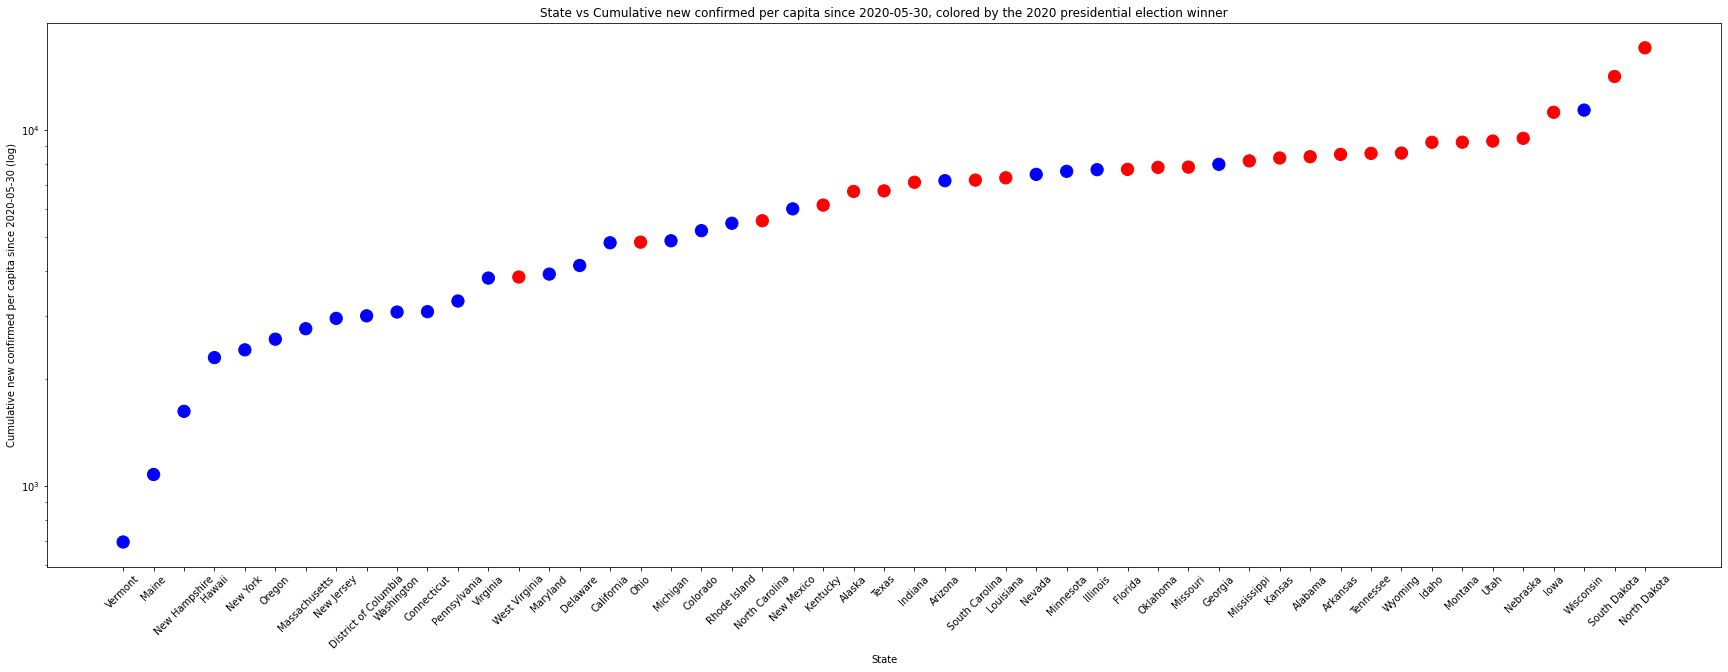

In [ ]:
# Drop NAN's
q6 = q6.dropna()

states = q6['state'].unique()

plt.figure(figsize=(30, 10))
xs = q6["state"]
ys = q6["cumulative_new_confirmed_per_capita"]
color = np.vectorize(lambda p : 'r' if p == 'republican' else 'b')
marker = np.vectorize(lambda p : 'x' if p == 'republican' else 'o')
plt.scatter(xs, ys, s=150, color=color(q6['election_winner_party']))
plt.title("State vs Cumulative new confirmed per capita since 2020-05-30, colored by the 2020 presidential election winner")
plt.xticks(rotation=45)
plt.yscale('log')
plt.xlabel("State")
plt.ylabel("Cumulative new confirmed per capita since 2020-05-30 (log)")

### Summary of Data Exploration
During the exploration, we found that average temperatures, mobility trends, population density and government stringency all share a negative correlation with the number of new cases per capita. We also found that each state varies greatly in terms of how well it handles the pandemic. However, too few features have a consistent and strong enough correlation with the number of new deaths per capita. This is because the number of deaths depend on so many factors not available in the selected datasets, such as mask usage, viral load, ventilation, hospital beds, testing speeds, etc. Detailed analysis can be found in individual sections. 

Therefore, we have decided to only pursue predictions of new cases instead of new deaths.

Note

    In fact, we did experiment with the prediction of new deaths to confirm our theory and it was indeed not very good - 38.7% recall, barely reaching 60% in accuracy and precision, and AUC is slightly above 60%. It is correct to not pursue prediction of new deaths per capita.

## Data Prediction

We will choose all the selected features along with states, which is an obvious feature, to predict the classification of the number of new cases per capita on a certain date.

### Determining the right threshold
We need to determine the right threshold for two classes of new confirmed cases per capita. We calculated the average of newly confirmed cases per capita among states to find the right threshold.

We will choose the peak of the first wave as the threshold $T$ for classification because the first wave was already extremely bad. Therefore, anything higher than the peak of the first wave should be considered as high. It's a tragedy that we are doing much worse than the first wave now.

This gives us 
$$T_\text{new confirmed} = 20$$

As a result, we classify `new_confirmed_per_capita` into two categories as discussed above:
* 0: low new infections per capita $\text{cases} < 20$
* 1: high new infections per capita $\text{cases} >= 20$

In [ ]:
%%bigquery --project $project_id qdp

WITH per_state_data AS (
SELECT
  covid19_open_data.date,
  pop_density.state,
  SUM(new_confirmed / population * 100000) new_confirmed_per_capita,
  SUM(new_deceased / population * 100000) new_deceased_per_capita,
FROM `bigquery-public-data.covid19_open_data.covid19_open_data` covid19_open_data,
`cs145-fa20-290805.Project3.us_pop_density` pop_density
WHERE covid19_open_data.subregion1_name = pop_density.state
GROUP BY covid19_open_data.date, pop_density.state
)
SELECT
  date,
  AVG(new_confirmed_per_capita) avg_new_confirmed_per_capita,
  AVG(new_deceased_per_capita) avg_new_deceased_per_capita
FROM per_state_data 
GROUP BY date
ORDER BY date

Text(0, 0.5, 'Avg New Cases Per Capita')

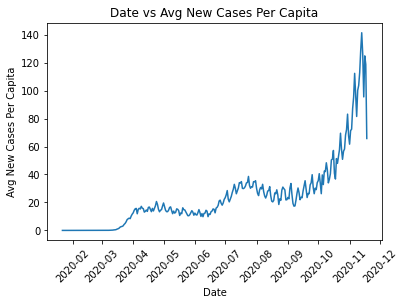

In [ ]:
qdp = qdp.dropna()

plt.figure()
plt.plot(qdp["date"], qdp["avg_new_confirmed_per_capita"])
plt.title("Date vs Avg New Cases Per Capita")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Avg New Cases Per Capita")

In [ ]:
# Run this cell to create a dataset to store your model, or create in the UI

model_dataset_name = 'bqml_covid19'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('cs145-fa20-290805', 'bqml_covid19'))

### Training the model
As a reminder, we classify `new_confirmed_per_capita` into two categories as discussed above:
* 0: low new infections per capita $\text{cases} < 20$
* 1: high new infections per capita $\text{cases} >= 20$

Note that here we use $\min{(\text{StringencyIndex})}$ because it's the same for each state. It doesn't matter whether we use min, max or avg.

In [ ]:
%%bigquery --project $project_id

# YOUR QUERY HERE

CREATE OR REPLACE MODEL `bqml_covid19.covid19_cases_model` -- we'll call our model 'covid19_cases_model'
OPTIONS(model_type='logistic_reg') AS
SELECT
  IF(SUM(new_confirmed / population * 100000) >= 20, 1, 0) label, # if new_confirmed_per_capita >= 20, then 1; else 0.
  subregion1_name state,
  AVG(average_temperature_celsius) avg_temp_celsius,
  AVG(mobility_retail_and_recreation) avg_mobility,
  MIN(us_gov_stringency.StringencyIndex) stringency,
  pop_density.density
FROM `bigquery-public-data.covid19_open_data.covid19_open_data` covid19_open_data,
`cs145-fa20-290805.Project3.us_pop_density` pop_density,
`cs145-fa20-290805.Project3.us_gov_stringency_processed` us_gov_stringency
WHERE "2020-04-30" < covid19_open_data.date AND covid19_open_data.date <= "2020-09-30" AND covid19_open_data.date = us_gov_stringency.date AND pop_density.state = us_gov_stringency.state AND covid19_open_data.subregion1_name = pop_density.state
GROUP BY covid19_open_data.subregion1_name, covid19_open_data.date, pop_density.density 
HAVING avg_temp_celsius IS NOT NULL AND avg_mobility IS NOT NULL

""


### Evaluate the model on validation set
Here we evaluate the model with dates between 10/1 and 10/20. The model performs quite well because it has good precision, recall and accuracy.

In [ ]:
%%bigquery --project $project_id

# YOUR QUERY HERE

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_covid19.covid19_cases_model`, (
SELECT
  IF(SUM(new_confirmed / population * 100000) >= 20, 1, 0) label, # if new_confirmed_per_capita >= 20, then 1; else 0.
  subregion1_name state,
  AVG(average_temperature_celsius) avg_temp_celsius,
  AVG(mobility_retail_and_recreation) avg_mobility,
  MIN(us_gov_stringency.StringencyIndex) stringency,
  pop_density.density
FROM `bigquery-public-data.covid19_open_data.covid19_open_data` covid19_open_data,
`cs145-fa20-290805.Project3.us_pop_density` pop_density,
`cs145-fa20-290805.Project3.us_gov_stringency_processed` us_gov_stringency
WHERE covid19_open_data.date BETWEEN '2020-10-01' AND '2020-10-20' AND covid19_open_data.date = us_gov_stringency.date AND pop_density.state = us_gov_stringency.state AND covid19_open_data.subregion1_name = pop_density.state
GROUP BY covid19_open_data.subregion1_name, covid19_open_data.date, pop_density.density 
HAVING avg_temp_celsius IS NOT NULL AND avg_mobility IS NOT NULL
))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.864407,0.790698,0.765455,0.825911,0.49727,0.827131


### Evaluate the model on test set
Here we evaluate the model with dates after 10/20, which should have roughly the same number of days as the validation set. The model performs quite well because it has good precision, recall and accuracy.

In [ ]:
%%bigquery --project $project_id

# YOUR QUERY HERE

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_covid19.covid19_cases_model`, (
SELECT
  IF(SUM(new_confirmed / population * 100000) >= 20, 1, 0) label, # if new_confirmed_per_capita >= 20, then 1; else 0.
  covid19_open_data.date,
  subregion1_name state,
  AVG(average_temperature_celsius) avg_temp_celsius,
  AVG(mobility_retail_and_recreation) avg_mobility,
  MIN(us_gov_stringency.StringencyIndex) stringency,
  pop_density.density
FROM `bigquery-public-data.covid19_open_data.covid19_open_data` covid19_open_data,
`cs145-fa20-290805.Project3.us_pop_density` pop_density,
`cs145-fa20-290805.Project3.us_gov_stringency_processed` us_gov_stringency
WHERE covid19_open_data.date > '2020-10-20' AND covid19_open_data.date = us_gov_stringency.date AND pop_density.state = us_gov_stringency.state AND covid19_open_data.subregion1_name = pop_density.state
GROUP BY covid19_open_data.subregion1_name, covid19_open_data.date, pop_density.density 
HAVING avg_temp_celsius IS NOT NULL AND avg_mobility IS NOT NULL
ORDER BY covid19_open_data.date DESC
))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.965746,0.754098,0.756923,0.846899,0.500159,0.863557


### Model Performance
The model performs quite well because as we can see from the test data, it has:
* High precision. $96.6\%$ of the positives this model predicted are true positives. 
* Good recall. $75.4\%$ of the real positives were correctly predicted by this model.
* Good accuracy. $75.7\%$ of the predicted labels were correct.

For a simple logistic regression model with limited data, the performance actually exceeded our expectations.

The model's performance showed that the features we chose were correct and indicative. It also confirmed our theory that lower temperature, lower mobility and higher stringency indicates lower new confirmed cases per capita. 

One little surprise is that the population density has a negative correlation instead of a positive one because theoretically a higher population density should result in more cases. However, more population density also indicates a more Democratic or liberal government, which generally believes more in science, social distancing and masks than the Republican or conservative counterpart, and we know that social distancing and wearing masks are the two most important things we can do to prevent the spread of the virus before universal vaccination.

## Conclusion

In conclusion, this project found that colder temperatures, higher government stringency index and a state less supportive of mask usage and social distancing indicate lower daily infections per capita as they share a negative correlation, just like we initially expected. However, we also found that a higher population density actually correlates fewer new cases per capita and that a decrease in mobility trend correlates with more new cases per capita, the opposite of what we expected. 

This, however, can be easily explained because:
1. a state with higher population density tends to be more Democratic and liberal and thus is more likely to have a higher mask usage and adherence to social distancing. 
2. when cases spike up, governments tend to enact policies to restrict unnecessary activities, and people often decide to stay home on their own. When cases go down, governments tend to lessen restrictions, and people usually go out more often.

Overall, the features we chose seem indicative of whether a state has a low or high number of new cases per capita on a certain date because our data analysis and visualization showed correlations, and our simple logistic regression model performed relatively well.

If we had more time, we would like to find out the relationship between mask usage, ICU beds availability and infection / mortality rate. However, we did not find adequate data from bigquery's public datasets and did not have time to find data that contain these information.